# **1. Introduction**

In this notebook, we will review how we have preprocessed the datasets. We will then proceed with the computation of the features. Next, we will perform a brief feature analysis and visualization. Finally, based on the insights gained in the previous section, we will preprocess the features to prepare them for training models for our task.

Our task is to compute the semantic similarity between two sentences using a supervised learning approach. For this, we will use the dataset provided in SemEval 2012.

Install dependencies

In [1]:
# Install the necessary libraries
%pip install pandas
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import required libraries

In [14]:
# Import the required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Standard Libraries
import os

# Data manipulation and analysis
import pandas as pd

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
import string

# Machine Learning
import joblib

# Download necessary NLTK data files
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet_ic')
nltk.download('brown')

from nltk.corpus import wordnet_ic
from nltk.corpus import brown
from nltk.corpus import wordnet as wn

wnl = nltk.stem.WordNetLemmatizer()

#Load the Information Content corpus

ic = wordnet_ic.ic('ic-brown.dat')

stopwords = set(stopwords.words('english'))

word_freq = nltk.FreqDist(w.lower() for w in brown.words())
total_freq = sum(word_freq.values())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\marcg\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already u

# **2. Data Loading**

In this section, we load the training and test datasets along with their corresponding gold standard similarity scores from various corpora. We begin by installing and importing the necessary libraries and packages. Next, we define a function to load and process the datasets, and we transform them into structured DataFrames for further analysis.

In [3]:
from scripts.load_dataset import load_dataset

data_dir = 'datasets'

# Load Training Data
train_data = load_dataset(data_dir, dataset_category='train')
columns = ['sentence_0', 'sentence_1', 'score', 'dataset_name']
train_data = pd.DataFrame(train_data, columns=columns)

# Load Test Data
test_data = load_dataset(data_dir, dataset_category='test')
columns = ['sentence_0', 'sentence_1', 'score', 'dataset_name']
test_data = pd.DataFrame(test_data, columns=columns)

# Display the number of samples in each dataset
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 2234
Number of test samples: 3108


# **3. Data Preprocessing**

Once the data is loaded, we apply preprocessing steps to prepare the datasets for feature extraction. Specifically, we:

1. Tokenize Sentences: Use NLTK's `word_tokenize` to split sentences into individual tokens.
2. Remove Punctuation: Eliminate punctuation tokens to retain only meaningful words.
3. Lemmatize Words: Apply NLTK's `WordNetLemmatizer` with Part-of-Speech (POS) tagging to reduce words to their base forms.
4. Lemma disambiguation: Apply Lesk algorithm to disambiguate lemmas. (Only used in some features)

Tokenize Sentences

In [4]:
train_data['tokens_0'] = train_data['sentence_0'].apply(nltk.word_tokenize)
train_data['tokens_1'] = train_data['sentence_1'].apply(nltk.word_tokenize)

test_data['tokens_0'] = test_data['sentence_0'].apply(nltk.word_tokenize)
test_data['tokens_1'] = test_data['sentence_1'].apply(nltk.word_tokenize)

Remove Punctuation

In [5]:
import string

def remove_punctuation_tokens(tokens):
    return [token for token in tokens if token not in string.punctuation]

train_data['tokens_0'] = train_data['tokens_0'].apply(remove_punctuation_tokens)
train_data['tokens_1'] = train_data['tokens_1'].apply(remove_punctuation_tokens)

test_data['tokens_0'] = test_data['tokens_0'].apply(remove_punctuation_tokens)
test_data['tokens_1'] = test_data['tokens_1'].apply(remove_punctuation_tokens)

Lemmatize Words

In [6]:
from scripts.preprocessing import lemmatize

# Obtain Lemmatized Words
train_data['lemmas_0'] = train_data.apply(lambda row: lemmatize(row, "tokens_0", nltk, wnl, True), axis=1)
train_data['lemmas_1'] = train_data.apply(lambda row: lemmatize(row, "tokens_1", nltk, wnl, True), axis=1)

test_data['lemmas_0'] = test_data.apply(lambda row: lemmatize(row, "tokens_0", nltk, wnl, True), axis=1)
test_data['lemmas_1'] = test_data.apply(lambda row: lemmatize(row, "tokens_1", nltk, wnl, True), axis=1)

# Join Lemmatized Words
train_data['sentence_lemmas_0'] = train_data.apply(lambda row: " ".join(row["lemmas_0"]), axis=1)
train_data['sentence_lemmas_1'] = train_data.apply(lambda row: " ".join(row["lemmas_1"]), axis=1)

test_data['sentence_lemmas_0'] = test_data.apply(lambda row: " ".join(row["lemmas_0"]), axis=1)
test_data['sentence_lemmas_1'] = test_data.apply(lambda row: " ".join(row["lemmas_1"]), axis=1)

Lemmas Disambiguation

In [8]:
from scripts.preprocessing import tokens_to_synsets_name

train_data['lemmas_with_disambiguation_0'] = train_data.apply(lambda row: tokens_to_synsets_name(row["lemmas_0"], nltk), axis=1)
train_data['lemmas_with_disambiguation_1'] = train_data.apply(lambda row: tokens_to_synsets_name(row["lemmas_1"], nltk), axis=1)

test_data['lemmas_with_disambiguation_0'] = test_data.apply(lambda row: tokens_to_synsets_name(row["lemmas_0"], nltk), axis=1)
test_data['lemmas_with_disambiguation_1'] = test_data.apply(lambda row: tokens_to_synsets_name(row["lemmas_1"], nltk), axis=1)

Save and Load Preprocessed Datasets

In [4]:
# Save Training and Test Data
train_data.to_csv('datasets/train_preprocessed.csv')
test_data.to_csv('datasets/test_preprocessed.csv')

In [3]:
# Load Training and Test Data
train_data = pd.read_csv('datasets/train_preprocessed.csv')
test_data = pd.read_csv('datasets/test_preprocessed.csv')

# **4. Feature Extraction**

### Lexical Features

1. **`longest_common_substring`**: 
   Calculates the length of the longest continuous sequence of characters or tokens shared between two sentences.
   
2. **`longest_common_subsequence`**: 
   Determines the length of the longest sequence of tokens that appear in the same order in both sentences, though not necessarily contiguous.

3. **`greedy_string_tiling`**: 
   Finds the longest contiguous matching substrings between two sentences using a greedy algorithm, reducing redundancy.

4. **Character n-gram Similarity Features (`2_gram_char`, `3_gram_char`, `4_gram_char`)**: 
   Measures similarity based on character-level n-grams (substrings of length 2, 3, or 4) using cosine similarity.

5. **Word n-gram Jaccard Similarity Features (`1_gram_word_Jaccard`, `3_gram_word_Jaccard`, `4_gram_word_Jaccard`)**: 
   Calculates Jaccard similarity between word-level n-grams (unigrams, trigrams, etc.) of two sentences.

6. **Word n-gram Jaccard Similarity Features without Stopwords**: 
   Similar to word n-gram Jaccard similarity, but removes stopwords before calculation to focus on meaningful words.

7. **Word n-gram Containment Similarity Features without Stopwords (`_a` and `_b` variants)**: 
   Computes containment similarity between word-level n-grams while excluding stopwords; `_a` and `_b` indicate different sentence orders as this function it's not commutative.

8. **`average_similarity`**: 
   Averages pairwise WordNet's Wu-Palmer similarity between tokens in two sentences, using the highest similarity for each token pair.

9. **`lexical_substitution_system`**: 
   Compares sentences at the lemma level with lexical disambiguation, assessing semantic similarity.

10. **`weighted_word_overlap`**: 
    Computes overlap of words weighted by their information content (rarer words contribute more to similarity).

---

### Syntactic Features

1. **`pathlen_similarity`**: 
   Uses WordNet to calculate path similarity (shortest path in the ontology) between words in two sentences.

2. **`lin_similarity`**: 
   Computes Lin similarity, which considers both shared and unique information content between WordNet synsets of sentence words.

3. **`wordnet_augmented_overlap`**: 
   Augments word overlap by incorporating WordNet-based similarity for non-matching words, using a harmonic mean of overlap scores.

4. **`wordnet_augmented_word_overlap`**: 
   Similar to `wordnet_augmented_overlap`, but measures it directly using WordNet path similarity.

5. **POS tag Ngram Overlap (`pos_2_ngram_overlap`, `pos_3_ngram_overlap`, `pos_4_ngram_overlap`)**: 
   Computes the overlap of part-of-speech tag sequences (e.g., bigrams or trigrams) between two sentences, focusing on structural patterns.


# **5. Feature Computation**

Here, we perform the computation of all the features described above. Note that this process may take some time. We recommend loading the features from the CSV file, which can be done in the third cell.

Most of all the features in our project have been extracted from the UKP and TakeLab papers.

In [ ]:
from scripts.compute_features import compute_features

features_train = compute_features(train_data, stopwords, nltk, wn, ic, word_freq, total_freq)
features_test = compute_features(test_data, stopwords, nltk, wn, ic, word_freq, total_freq)

Save the features computed to CSV's to be able to reload them instead of computing them again.

In [6]:
# Save Training Features to a CSV File
features_train.to_csv('features/features_train.csv', index=False)

# Save Test Features to a CSV File
features_test.to_csv('features/features_test.csv', index=False)

Load precomputed features

In [17]:
# Load Training and Test Features
features_train = pd.read_csv('features/features_train.csv')
features_test  = pd.read_csv('features/features_test.csv')

Display for context

In [36]:
features_train.head()

,Unnamed: 0,longest_common_substring,longest_common_subsequence,greedy_string_tiling,2_gram_char,3_gram_char,4_gram_char,1_gram_word_Jaccard,3_gram_word_Jaccard,4_gram_word_Jaccard,2_gram_word_Jaccard_without_SW,4_gram_word_Jaccard_without_SW,1_gram_word_Containment_without_SW_a,2_gram_word_Containment_without_SW_a,1_gram_word_Containment_without_SW_b,2_gram_word_Containment_without_SW_b,average_similarity,lexical_substitution_system,wordnet_augmented_overlap
0,0,69,97,69,0.797310,0.722290,0.632530,0.533333,0.342857,0.323529,0.444444,0.375000,0.562500,0.533333,0.750000,0.727273,0.633658,0.772088,0.773645
1,1,24,49,24,0.666997,0.515727,0.461880,0.388889,0.047619,0.000000,0.307692,0.181818,0.857143,0.666667,0.500000,0.363636,0.780363,0.521026,0.659982
2,2,25,52,25,0.700097,0.547782,0.434828,0.333333,0.074074,0.038462,0.058824,0.000000,0.555556,0.125000,0.454545,0.100000,0.574525,0.799408,0.619091
3,3,124,127,124,0.926470,0.852009,0.827556,0.607143,0.576923,0.560000,0.555556,0.500000,0.916667,0.909091,0.611111,0.588235,0.827160,0.805629,0.808532
4,4,20,57,20,0.597739,0.367355,0.282144,0.192308,0.000000,0.000000,0.050000,0.000000,0.250000,0.090909,0.272727,0.100000,0.547487,0.462910,0.492864


In [11]:
print(len(features_train.columns))

25


Through this process, we can see that the number of features is 25. These are all the features used in this project.

# **6. Feature Visualization**

Now, we will perform feature visualization, as it can be insightful both for the reader and for us. This will help us better understand our features and potentially guide future preprocessing steps to improve model performance.

In [12]:
features_train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
longest_common_substring,2234.0,27.387645,20.533789,2.000000,12.000000,21.000000,37.000000,154.000000
longest_common_subsequence,2234.0,64.525962,50.562651,6.000000,21.000000,55.000000,91.000000,318.000000
greedy_string_tiling,2234.0,27.387645,20.533789,2.000000,12.000000,21.000000,37.000000,154.000000
2_gram_char,2234.0,0.673598,0.191951,0.014505,0.575415,0.708024,0.817097,1.000000
3_gram_char,2234.0,0.534961,0.204176,0.000000,0.407262,0.552196,0.676593,1.000000
4_gram_char,2234.0,0.459163,0.210085,0.000000,0.316286,0.468291,0.609231,1.000000
1_gram_word_Jaccard,2234.0,0.459744,0.174951,0.000000,0.333333,0.444444,0.571429,1.000000
3_gram_word_Jaccard,2234.0,0.158480,0.170610,0.000000,0.014135,0.115385,0.230769,1.000000
4_gram_word_Jaccard,2234.0,0.103913,0.157598,0.000000,0.000000,0.034483,0.153846,1.000000
2_gram_word_Jaccard_without_SW,2234.0,0.198617,0.212060,0.000000,0.000000,0.153846,0.300000,1.000000


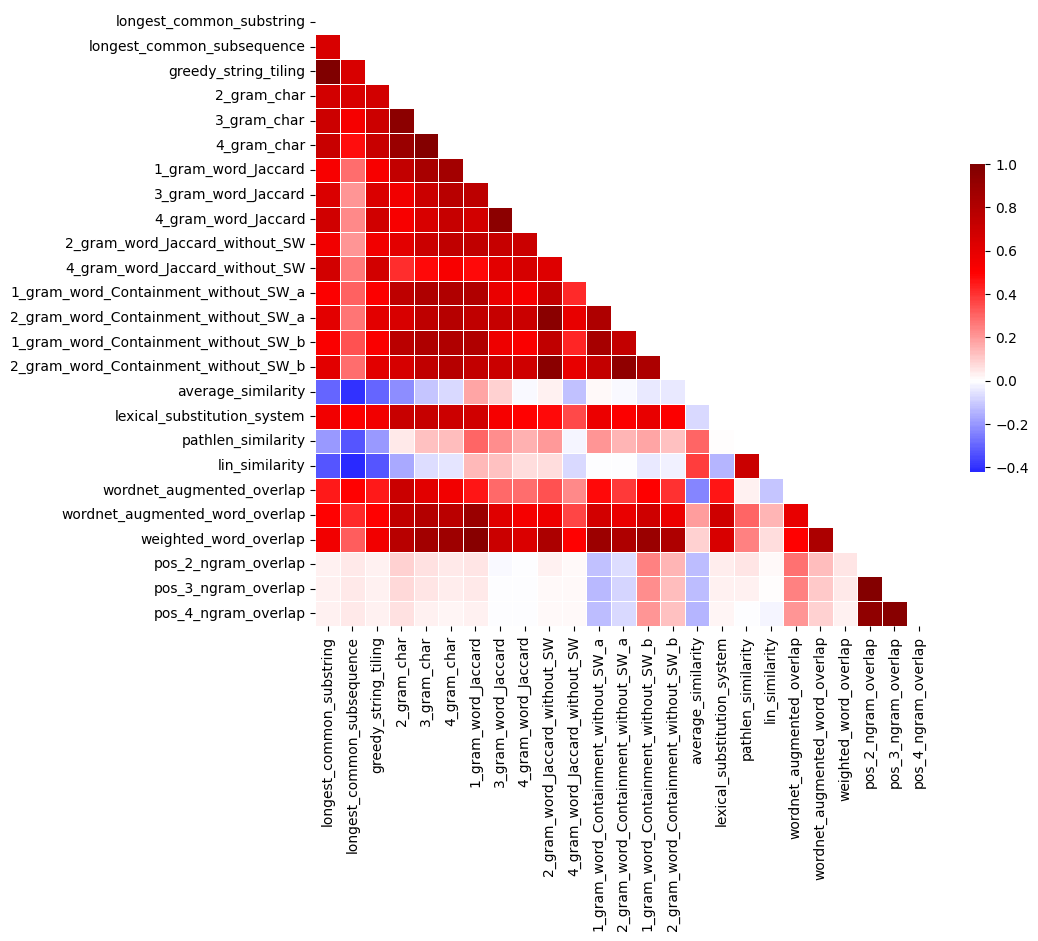

In [15]:
corr = features_train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

As observed above, there are strong correlations between some features, particularly the lexical ones. This is expected, as many of them aim to compute similarity, resulting in closely related outcomes. In other contexts, where features are expected to be completely independent, such strong correlations could indicate potential issues with feature extraction. However, that is not the case here.

Now, we will examine the distributions of the variables, as this is often very insightful. These distributions will help guide the preprocessing of the features.

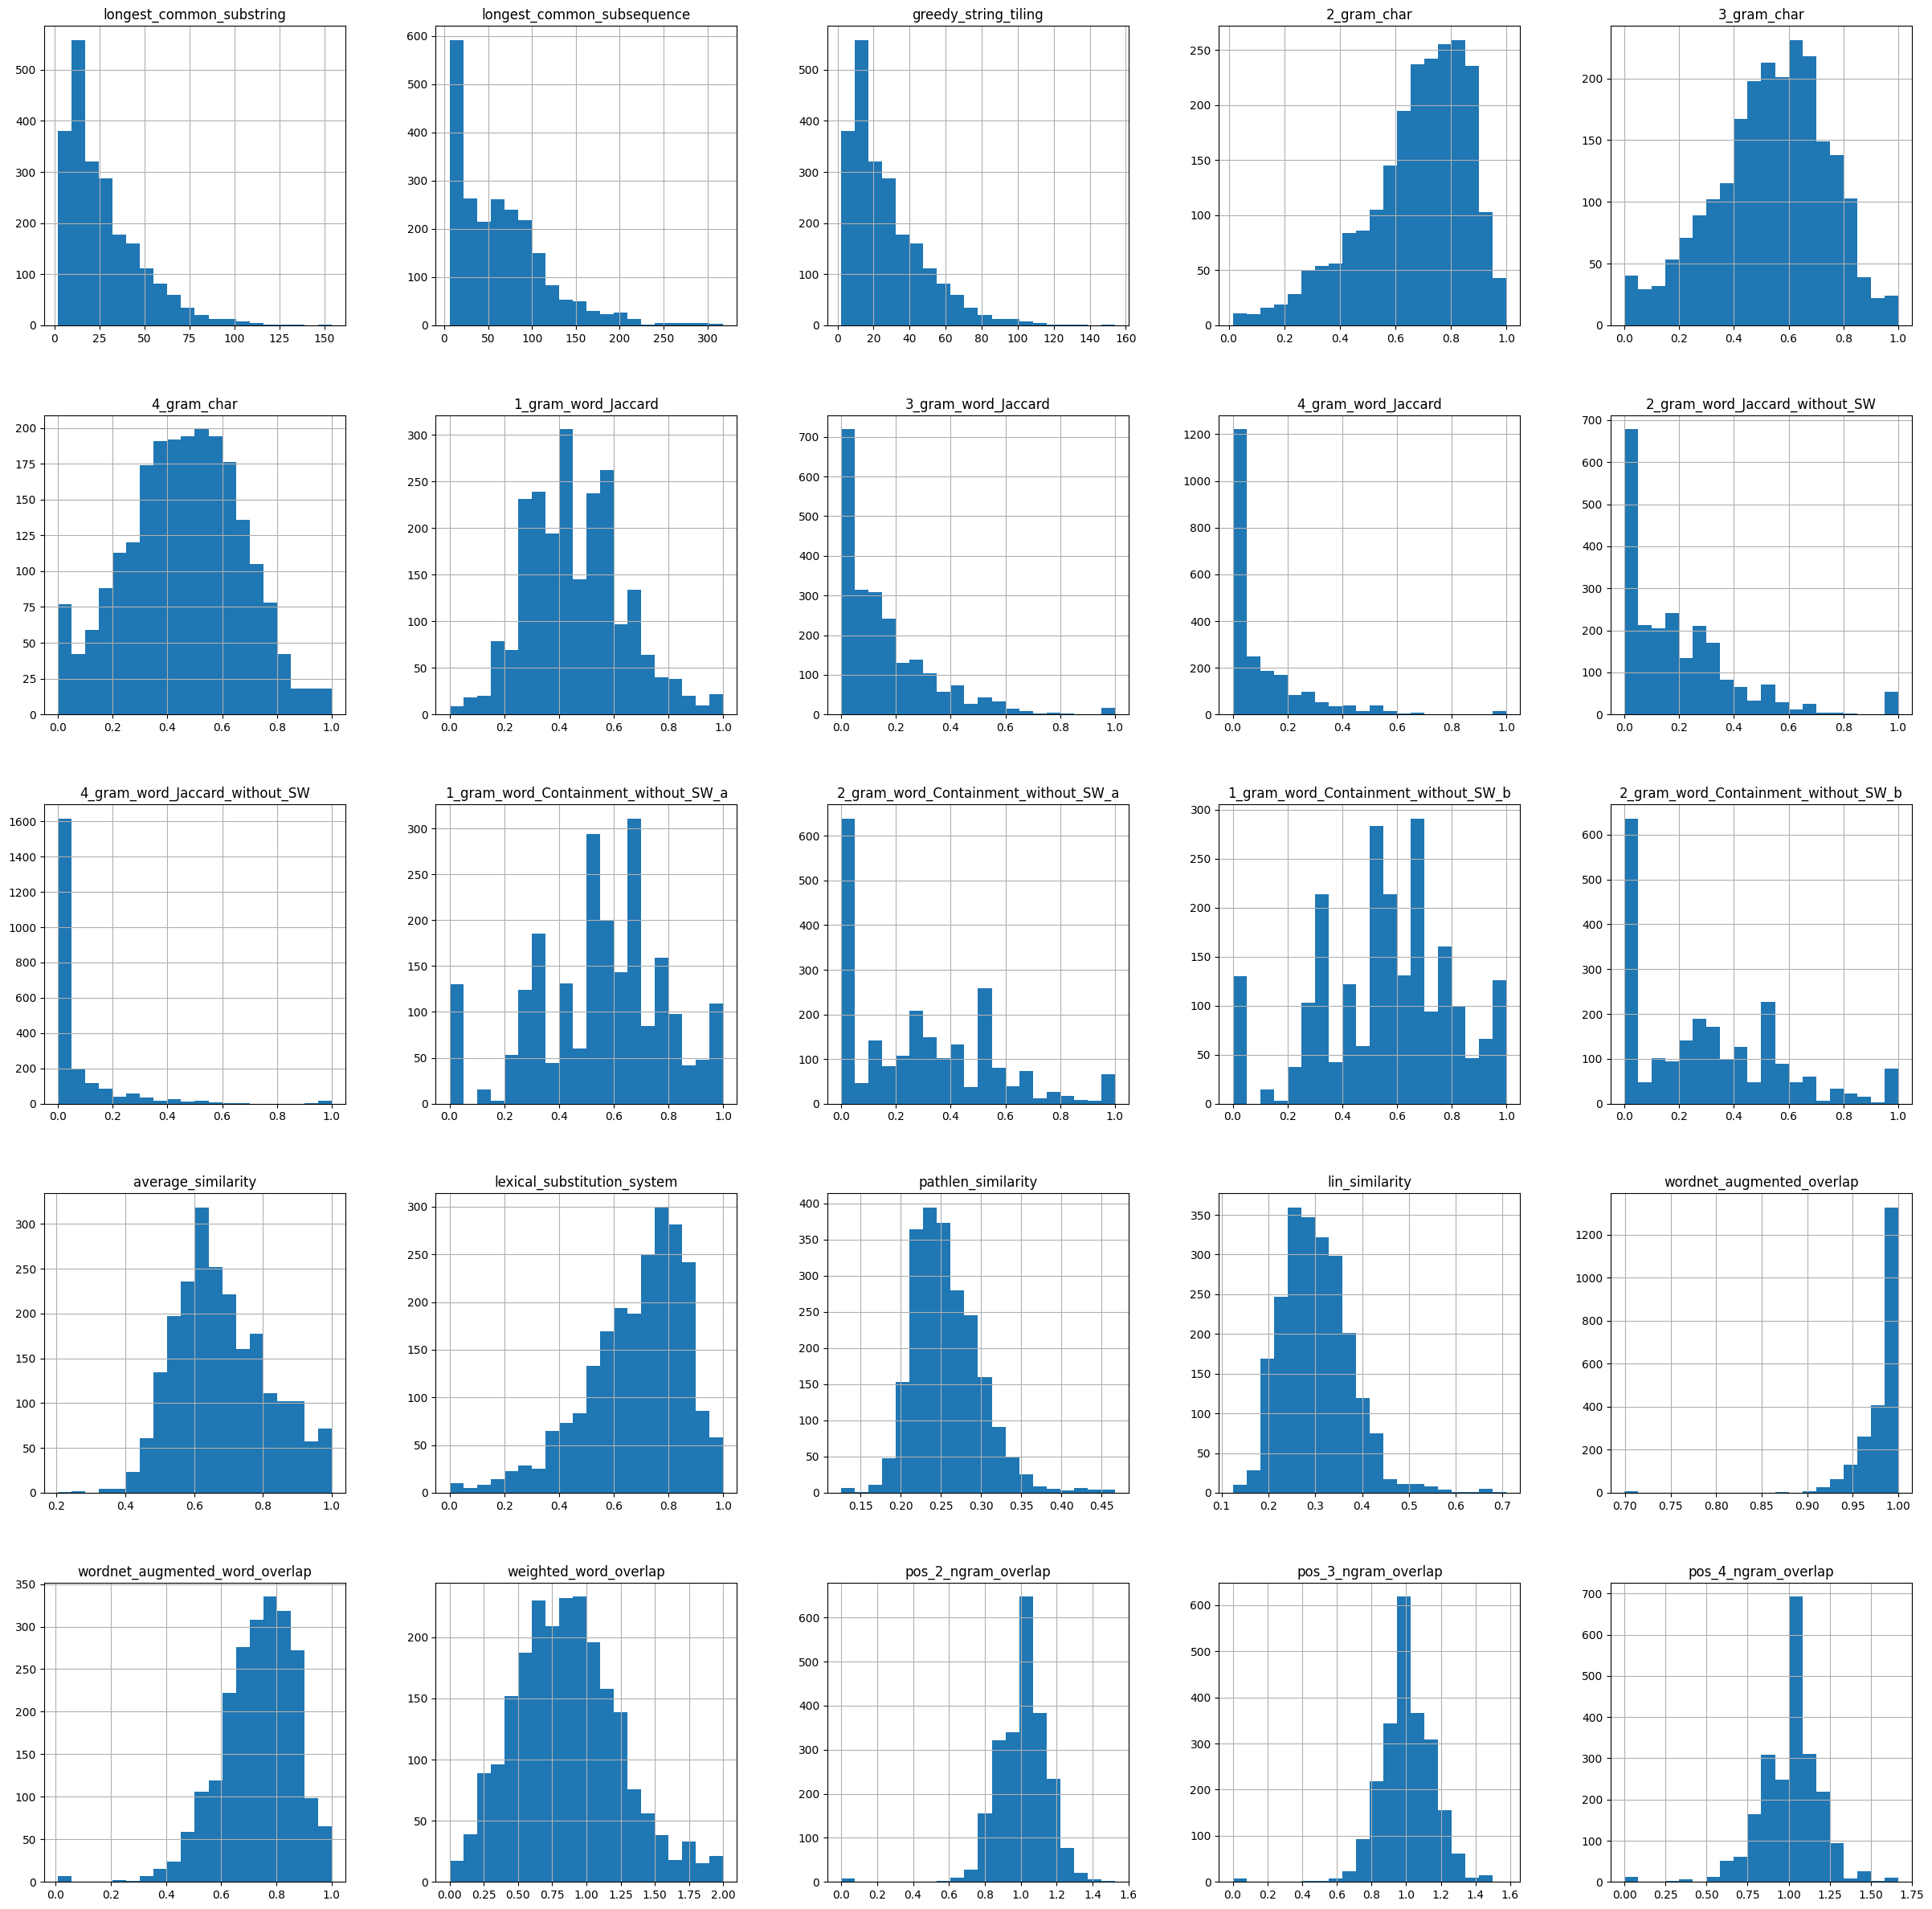

In [18]:
_=features_train.hist(bins=20,figsize=(30,30))

As we can see, our variables have different distributions. However, most of them follow a well-defined distribution, which is beneficial for our model.

# **7. Feature Preprocessing**

Based on the visualization of the distributions, we will now perform feature preprocessing. In this case, we will apply three types of preprocessing:

1. **Logarithmic Transformation**:  
   For features with a right-skewed distribution (tail to the right and most of the weight to the left), we will apply a logarithmic transformation to center the distributions and make them more Gaussian-like.

2. **Yeo-Johnson Transformation**:  
   For features with a left-skewed distribution (tail to the left), we will use the power-based Yeo-Johnson transformation to approximate a Gaussian distribution.

3. **No Preprocessing**:  
   For features that are already centered (Gaussian) or follow unusual distributions, we have decided not to apply any preprocessing.

In [19]:
from sklearn.preprocessing import PowerTransformer

# Initialize Yeo-Johnson power transformer
power_transformer = PowerTransformer(method='yeo-johnson')

# List of columns to apply log1p transformation
log_transform_cols = [
    "longest_common_substring", "longest_common_subsequence",
    "greedy_string_tiling", "3_gram_word_Jaccard",
    "4_gram_word_Jaccard", "2_gram_word_Jaccard_without_SW",
    "pathlen_similarity", "lin_similarity", "weighted_word_overlap"
]

# Apply log1p transformation to specified training features
for col in log_transform_cols:
    features_train[col] = np.log1p(features_train[col])

# Apply Yeo-Johnson transformation to selected training features
features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.fit_transform(features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])

# Apply log1p transformation to specified test features
for col in log_transform_cols:
    features_test[col] = np.log1p(features_test[col])

# Apply the Yeo-Johnson transformation to selected test features
features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.transform(features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])

Now we will review, the results of our feature preprocessing.

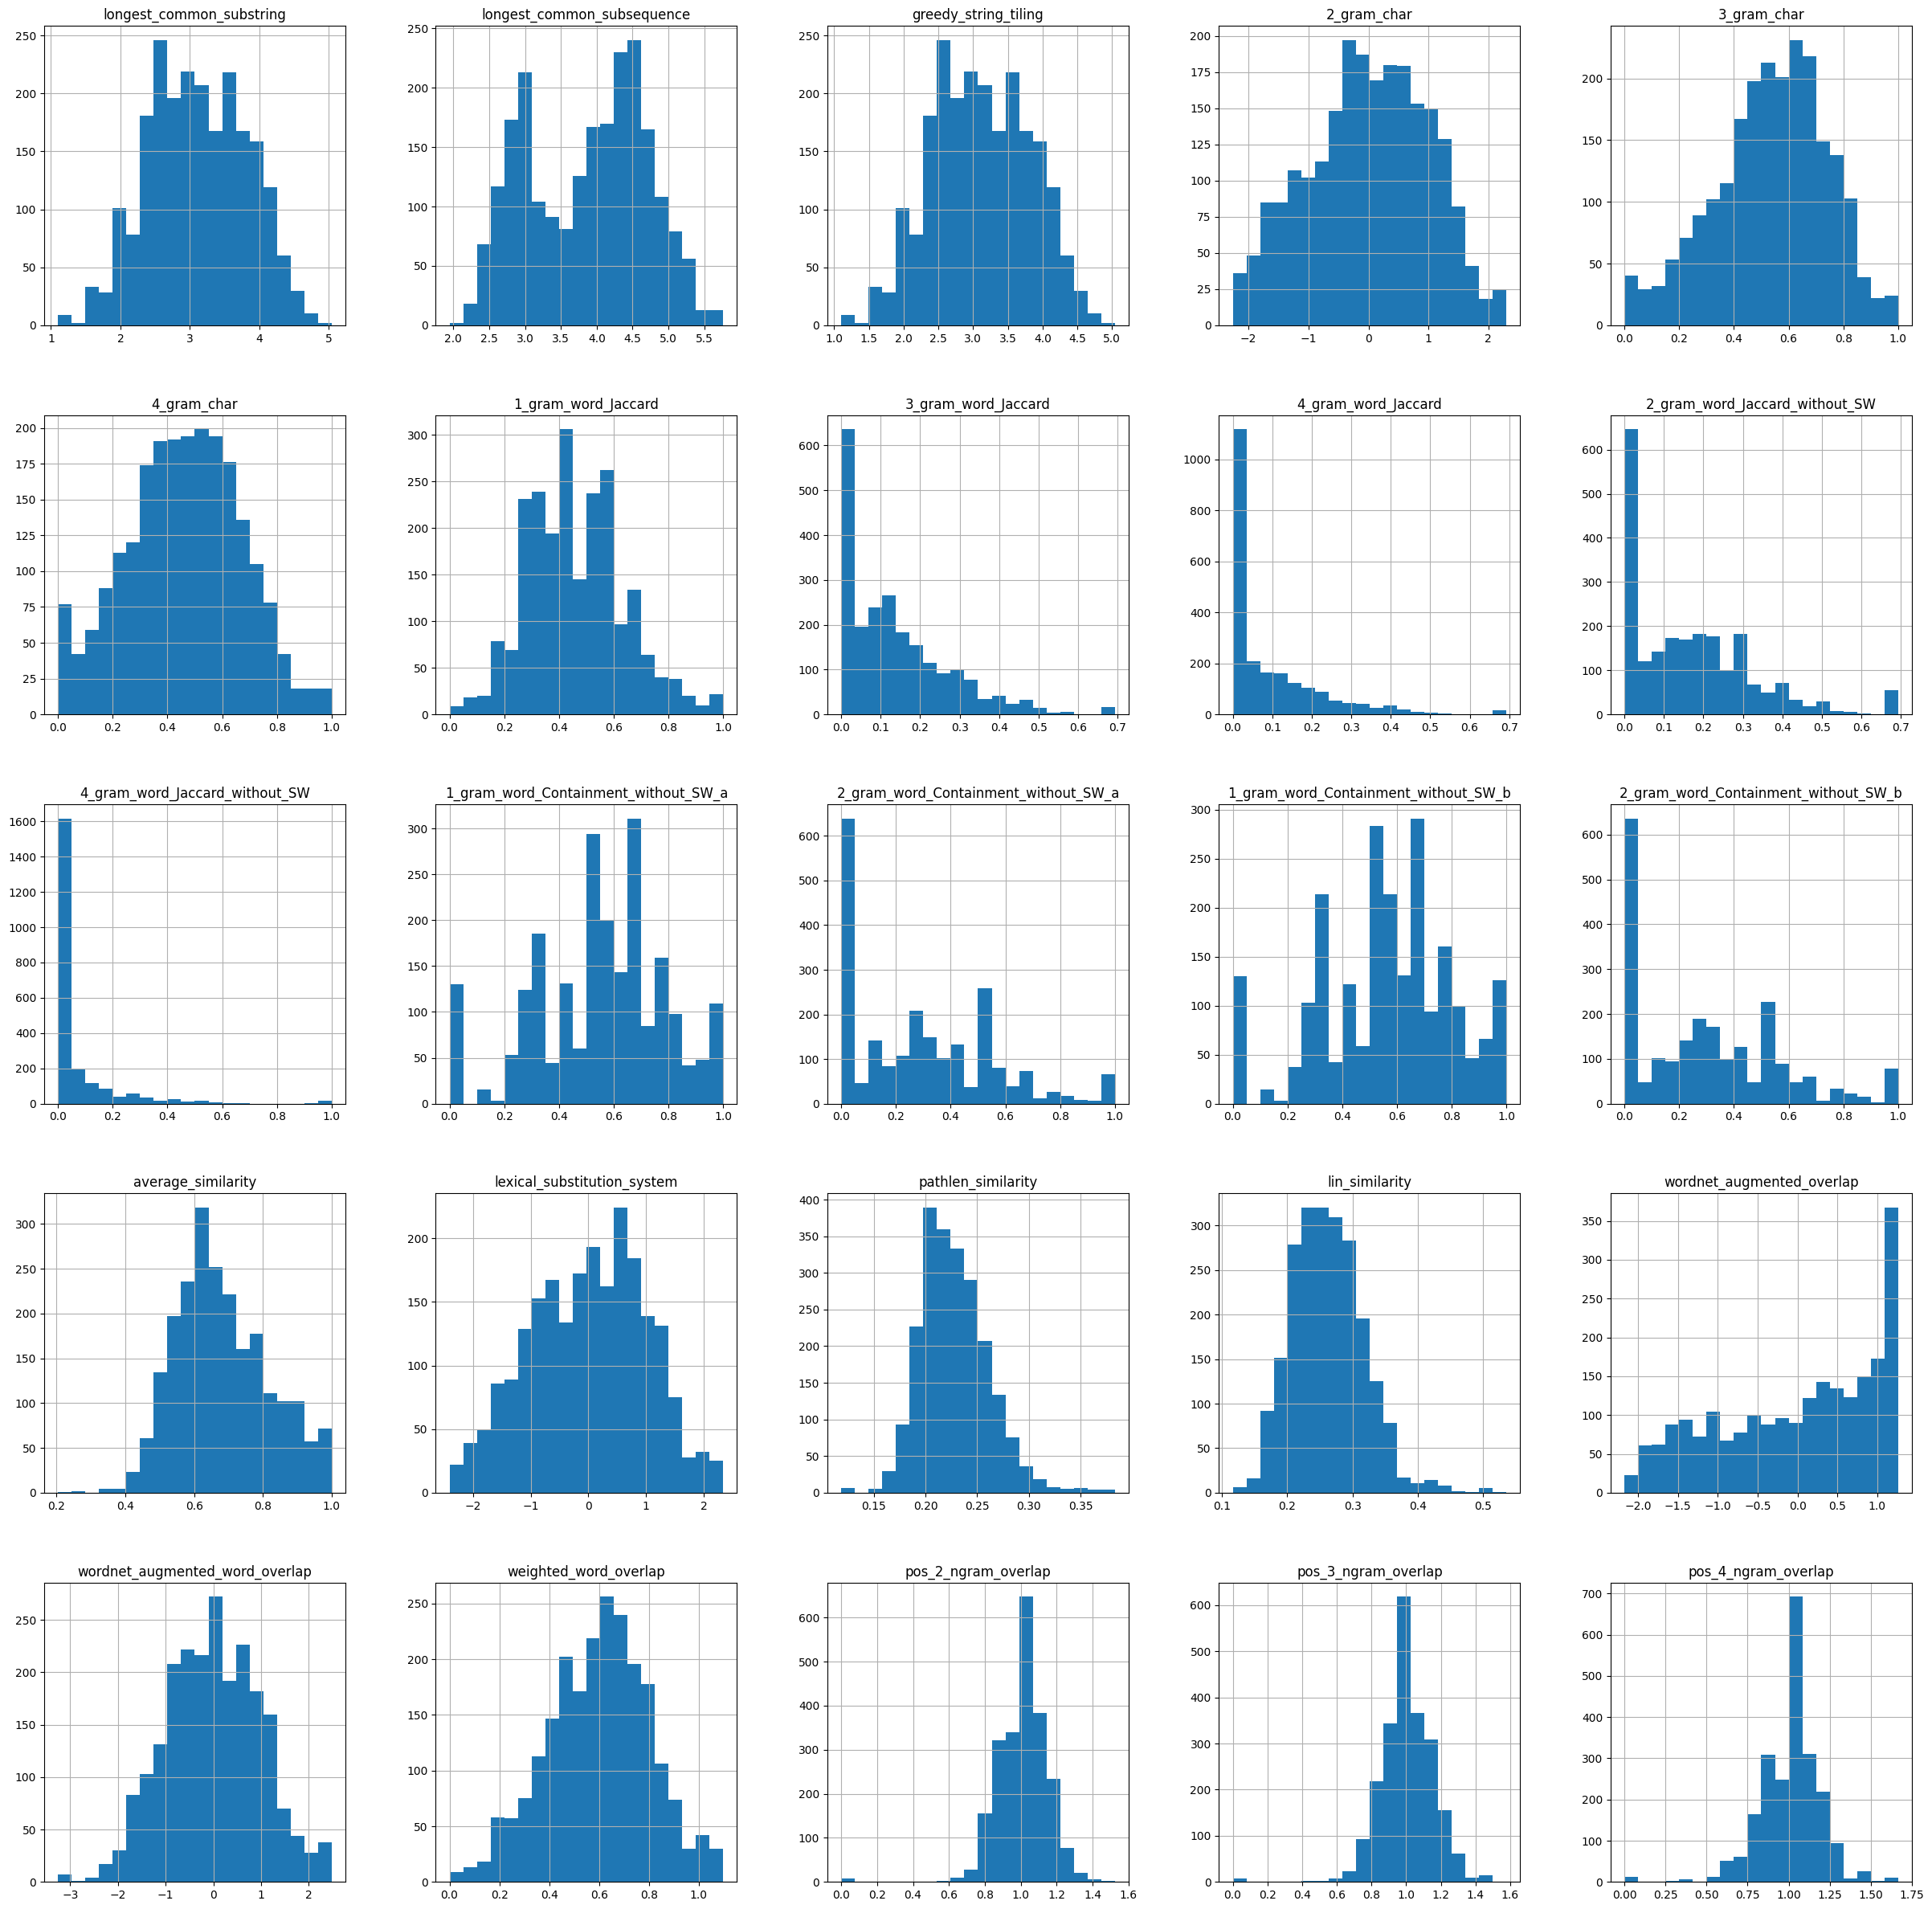

In [20]:
_=features_train.hist(bins=20,figsize=(30,30))

As we can see, our preprocessing has worked quite well. We have managed to center many of the distributions and make them more Gaussian. Additionally, distributions that were highly clustered on one side, usually the left, have been spread out and expanded in range, making the task easier for our models later on.

Finally we store the preprocessed features, to be able to load it in the training_and_results notebook, where they will be used to train our models.

In [21]:
# Save Training Features to a CSV File
features_train.to_csv('features/features_preprocessed_train.csv', index=False)

# Save Test Features to a CSV File
features_test.to_csv('features/features_preprocessed_test.csv', index=False)